In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import os
import sys
from dotenv import load_dotenv

In [81]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [82]:
from src.sql_handling.execute_sql import execute_sql_pandas

In [83]:
load_dotenv()

# path to save figures
output_path = os.getenv("AUDIO_OUT")

# Global configuration path
glob_conf_path = '../global_config.py'

In [84]:
exec(open(glob_conf_path).read())

# Select data

In [85]:
query = """SELECT *
FROM opensmile_functionals
WHERE mix = 0
AND video_id IN ('A101', 'A102', 'A18', 'A200')"""
df, read_duration = execute_sql_pandas(query)

In [86]:
print("query executed in: {} seconds".format(read_duration))

query executed in: 0.192 seconds


In [87]:
df

,filename,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,...,mix,emotion_1,emotion_1_id,emotion_2,emotion_2_id,proportions,mode,intensity_level,version,situation
0,A102_ten_p_2,/media/tim/Seagate Backup Plus Drive/Documents...,0 days,0 days 00:00:05.380000,37.364210,0.012795,37.054905,37.203660,37.935577,0.880672,...,0,ten,28,,100,0,p,2,1,1
1,A200_det_v_2,/media/tim/Seagate Backup Plus Drive/Documents...,0 days,0 days 00:00:02.520000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,det,2,,100,0,v,2,1,1
2,A200_bor_p_4,/media/tim/Seagate Backup Plus Drive/Documents...,0 days,0 days 00:00:03.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,bor,26,,100,0,p,4,1,1
3,A18_disa_p_1,/media/tim/Seagate Backup Plus Drive/Documents...,0 days,0 days 00:00:02.920000,34.849487,0.022767,34.441685,34.968440,35.538372,1.096687,...,0,disa,37,,100,0,p,1,1,1
4,A102_neg_sur_v_4,/media/tim/Seagate Backup Plus Drive/Documents...,0 days,0 days 00:00:07.300000,52.813877,0.135019,46.113476,51.576890,60.985962,14.872486,...,0,neg_sur,11,,100,0,v,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,A18_tri_v_3,/media/tim/Seagate Backup Plus Drive/Documents...,0 days,0 days 00:00:02.880000,40.385273,0.142799,38.905945,40.100864,45.588783,6.682838,...,0,tri,20,,100,0,v,3,1,1
1392,A18_rel_p_2,/media/tim/Seagate Backup Plus Drive/Documents...,0 days,0 days 00:00:02.600000,30.386702,0.070326,29.140274,30.515236,32.025208,2.884933,...,0,rel,38,,100,0,p,2,1,1
1393,A101_env_p_4,/media/tim/Seagate Backup Plus Drive/Documents...,0 days,0 days 00:00:03.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,env,4,,100,0,p,4,1,1
1394,A101_disa_p_1,/media/tim/Seagate Backup Plus Drive/Documents...,0 days,0 days 00:00:03.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,disa,37,,100,0,p,1,1,1


In [88]:
df = df.drop(columns=["file", "start", "end", "mix", "emotion_2", "emotion_2_id",  
                      "proportions", "mode", "intensity_level",
                      "version", "situation"])

In [89]:
df.columns.values

array(['filename', 'F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
       'loudness_sma3_amean', 'loudness_sma3_stddevNorm',
       'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0',
       'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2',
       'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope',
       'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean',
       'mfcc1_sma3_s

# Data inspection before data cleaning
In this section we will inspect the dataset. For this porpuse, we will focus on the number of files per emotion

Files per emotion before data cleaning
Total number of files: 1396
emotion_1
adm        32
amu        32
ang        32
anx        32
awe        32
bor        32
conc       32
conf       31
cont       32
det        32
disa       32
disg       32
dist       32
dou        31
ele        32
emb        31
env        32
exc        32
fea        32
gra        28
gui        32
hap        32
hop        32
ins        31
int        32
mov        32
neg_sur    32
neu        32
nos        32
pea        32
ple        31
pos_sur    32
pri        32
reg        32
rej        31
rel        32
sad        32
sar        32
sat        32
scha       32
sex        30
sha        32
ten        32
tri        32
Name: filename, dtype: int64


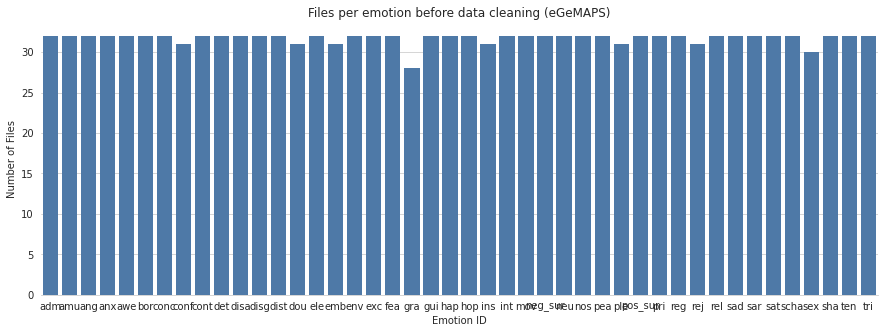

In [90]:
print('Files per emotion before data cleaning')
files_per_emotion_count_original = df[['emotion_1','filename']].groupby(['emotion_1']).filename.nunique()
print('Total number of files: {}'.format(files_per_emotion_count_original.sum()))
print(files_per_emotion_count_original)
plt.figure(figsize=(15,5))
sns.barplot(files_per_emotion_count_original.index, files_per_emotion_count_original.values, saturation=sns_saturation, color=blue_rgb)
plt.title('Files per emotion before data cleaning (eGeMAPS)')
plt.xlabel('Emotion ID')
plt.ylabel('Number of Files')
plt.show()
print()

In [91]:
# check for null values
df.isnull().values.any()

False

# Normalize training set


In [92]:
from sklearn import preprocessing

# eGeMAPS
X = df.drop(columns=['emotion_1','emotion_1_id','filename','video_id'])          # Get features from training set
min_max_scaler_egemaps = preprocessing.MinMaxScaler()                     # eGeMAPS min max scaler
X_scaled = min_max_scaler_egemaps.fit_transform(X)                        # Fit and transform features
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns.to_list())    # Create a dataframe from normalized features
metadata_df = df[['emotion_1_id','filename','video_id']]
train_scaled_df = pd.concat([X_scaled_df,metadata_df], axis=1)

In [93]:
train_egemaps_scaled_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,emotion_1_id,filename,video_id
0,0.650444,0.233652,0.634122,0.662218,0.676610,0.083160,0.143866,0.068505,0.281647,0.004778,...,0.124404,0.193258,0.102118,0.161909,0.011009,0.026035,0.692619,18,A050121-R_awe_p_3,A050121-R
1,0.723358,0.225872,0.712805,0.745209,0.757043,0.088237,0.144350,0.090496,0.284680,0.020590,...,0.072070,0.066926,0.218824,0.132388,0.034051,0.114463,0.801554,12,A223_ang_p_4,A223
2,0.375483,0.141200,0.346960,0.378856,0.395157,0.082627,0.112252,0.000000,0.262541,0.018866,...,0.042265,0.059516,0.056471,0.000000,0.041606,0.020101,0.541971,7,A65_gra_v_2,A65
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100904,0.000000,0.269371,0.000000,...,0.023704,0.000000,0.000000,0.000000,0.082402,0.000000,0.330187,5,A323_adm_v_1,A323
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100904,0.000000,0.269371,0.000000,...,0.035776,0.000000,0.000000,0.000000,0.222924,0.000000,0.427408,6,A72_sad_v_2,A72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11057,0.552514,0.227825,0.531708,0.551417,0.591151,0.105169,0.085310,0.000000,0.276539,0.000000,...,0.027164,0.037969,0.251765,0.000000,0.054719,0.139866,0.677953,26,A050121-R_bor_v_3,A050121-R
11058,0.645919,0.501045,0.559269,0.604028,0.838773,0.433499,0.384561,0.431154,0.314473,0.068307,...,0.162627,0.404706,0.027941,0.049726,0.007393,0.066013,0.644973,6,A303_sad_v_4,A303
11059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100904,0.000000,0.269371,0.000000,...,0.023480,0.000000,0.000000,0.000000,0.169176,0.000000,0.434768,31,A200_sar_v_3,A200
11060,0.556397,0.116414,0.545811,0.561913,0.564084,0.044350,0.345016,0.415778,0.280416,0.008824,...,0.117255,0.274760,0.051294,0.094060,0.009606,0.062461,0.723064,7,A34_gra_p_3,A34


In [94]:
train_scaled_df.video_id.unique()

array(['A102', 'A200', 'A18', 'A101'], dtype=object)

In [95]:
def get_evens(size):
    ret = []
    for n in range(size):
        if n % 2 == 0:
            ret.append(n)
    return ret

def get_odds(size):
    ret = []
    for n in range(size):
        if n % 2 == 1:
            ret.append(n)
    return ret

In [96]:
import random

video_ids = train_scaled_df.video_id.unique()

# Find random pairs of video_ids
random.seed(seed)

# a list of even numbers
video_ids_1 = get_evens(len(video_ids))

# a list of odd numbers
video_ids_2 = get_odds(len(video_ids))

# shuffle the odd numbers
video_ids_2_shuffled = random.sample(video_ids_2, len(video_ids_2))

# assign groups for video ids by using odd and even numbers respectively
groups = {}
for i, video_id in enumerate(video_ids_1):
    groups[video_ids[video_id]] = i
    
for i, video_id in enumerate(video_ids_2_shuffled):
    groups[video_ids[video_id]] = i
    
print(groups)

# Create a copy
train_scaled_groups_df = train_scaled_df.copy()

# Insert group column
train_scaled_groups_df['group'] = train_scaled_groups_df['video_id'].map(groups)

{'A102': 0, 'A18': 1, 'A101': 0, 'A200': 1}


In [97]:
train_scaled_groups_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,emotion_1_id,filename,video_id,group
0,0.657078,0.041763,0.662575,0.644149,0.619569,0.041368,0.047625,0.001292,0.160562,0.022218,...,0.139509,0.009988,0.015686,0.076025,0.282590,0.620294,28,A102_ten_p_2,A102,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.149527,0.000000,0.558196,2,A200_det_v_2,A200,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.229022,0.000000,0.542611,26,A200_bor_p_4,A200,1
3,0.612855,0.074314,0.615848,0.605448,0.580418,0.051515,0.049450,0.012968,0.168346,0.036655,...,0.258947,0.083645,0.301419,0.028233,0.108807,0.692252,37,A18_disa_p_1,A18,1
4,0.928772,0.440709,0.824550,0.893009,0.996032,0.698609,0.108564,0.000000,0.000000,0.000000,...,0.033978,0.082397,0.000000,0.215457,0.446689,0.664815,11,A102_neg_sur_v_4,A102,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,0.710205,0.466103,0.695673,0.694311,0.744563,0.313915,0.115807,0.087605,0.277935,0.188563,...,0.174468,0.234082,0.723728,0.026919,0.116393,0.855178,20,A18_tri_v_3,A18,1
1392,0.534373,0.229548,0.521054,0.528345,0.523040,0.135515,0.121873,0.152214,0.167102,0.008937,...,0.486166,0.079401,0.245513,0.009253,0.079583,0.755614,38,A18_rel_p_2,A18,1
1393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.221451,0.000000,0.508662,4,A101_env_p_4,A101,0
1394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037444,0.000000,0.153927,0.000000,...,0.000000,0.000000,0.000000,0.240379,0.000000,0.477590,37,A101_disa_p_1,A101,0


In [98]:
save_path = os.path.join(output_path, 'audio_data_egemaps_train.csv')
train_scaled_groups_df.to_csv(save_path, index=None, header=True)